A

In [1]:
# Cell 1
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json, sys, importlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

# sample images (adjust if you uploaded samples to /kaggle/input/)
sample_paths = [
    Path("/kaggle/input/cvpr-mini-project-dataset/dataset/train/denomination_20/20_00001.jpg"),
    Path("/kaggle/input/cvpr-mini-project-dataset/dataset/train/denomination_20/20_00004.jpg"),
    Path("/kaggle/input/cvpr-mini-project-dataset/dataset/train/denomination_20/20_00006.jpg"),
]
DATASET_ROOT = Path("/kaggle/input/cvpr-mini-project-dataset/dataset")
TEMPLATE_DIR = DATASET_ROOT / "templates"

In [2]:
# Cell 2
def imshow_rgb(img, title=None, dpi=120):
    if img is None:
        print("None image")
        return
    if len(img.shape) == 2:
        plt.figure(dpi=dpi); plt.imshow(img, cmap='gray')
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(dpi=dpi); plt.imshow(img_rgb)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [3]:
# Cell 3
def resize_max(image, max_dim=1200):
    h,w = image.shape[:2]
    if max(h,w) <= max_dim:
        return image
    scale = max_dim / max(h,w)
    return cv2.resize(image, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

def order_points(pts):
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_warp(image, pts, output_size=None, extra_border=0.02):
    rect = order_points(np.array(pts, dtype="float32"))
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))
    if maxWidth < 2 or maxHeight < 2:
        return None, None
    pad_w = int(maxWidth * extra_border)
    pad_h = int(maxHeight * extra_border)
    dst = np.array([
        [0 + pad_w, 0 + pad_h],
        [maxWidth - 1 - pad_w, 0 + pad_h],
        [maxWidth - 1 - pad_w, maxHeight - 1 - pad_h],
        [0 + pad_w, maxHeight - 1 - pad_h]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    if output_size is not None:
        warped = cv2.resize(warped, output_size, interpolation=cv2.INTER_AREA)
    return warped, M

def ensure_landscape(img):
    h,w = img.shape[:2]
    if h > w:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img

In [4]:
# Cell 4
def create_orb(nfeatures=2000):
    return cv2.ORB_create(nfeatures)

def create_sift():
    if hasattr(cv2, 'SIFT_create'):
        return cv2.SIFT_create()
    try:
        return cv2.xfeatures2d.SIFT_create()
    except Exception:
        return None

def compute_kp_desc(detector, img_gray):
    kp, desc = detector.detectAndCompute(img_gray, None)
    return kp, desc

def match_descriptors(desc1, desc2, crossCheck=True):
    if desc1 is None or desc2 is None:
        return []
    # choose matcher based on dtype
    if desc1.dtype == np.uint8:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    else:
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    matches = bf.match(desc1, desc2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

In [5]:
# Cell 5
def find_homography_from_matches(kp1, kp2, matches, reproj_thresh=5.0, min_matches=8):
    if len(matches) < min_matches:
        return None, None, 0
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, reproj_thresh)
    if H is None:
        return None, None, 0
    matches_mask = mask.ravel().tolist()
    inlier_count = int(np.sum(matches_mask))
    return H, matches_mask, inlier_count

def homography_sanity_check(mapped_corners, img_shape, min_area_ratio=0.02, max_skew=5.0):
    # mapped_corners: (4,2)
    h,w = img_shape[:2]
    # area
    area = 0.5 * abs(np.dot(mapped_corners[:,0], np.roll(mapped_corners[:,1],1)) - np.dot(mapped_corners[:,1], np.roll(mapped_corners[:,0],1)))
    if area < h*w*min_area_ratio:
        return False
    # check bounding box ratio not extreme
    xs = mapped_corners[:,0]; ys = mapped_corners[:,1]
    bw = xs.max() - xs.min(); bh = ys.max() - ys.min()
    if bw <= 10 or bh <= 10:
        return False
    aspect = bw / max(bh,1)
    if aspect > max_skew or aspect < 1.0/max_skew:
        return False
    # no self-intersect (simple convexity check)
    try:
        from shapely.geometry import Polygon
        poly = Polygon(mapped_corners)
        if not poly.is_valid or not poly.is_convex:
            return False
    except Exception:
        pass
    return True

In [6]:
# Cell 6
def match_and_warp_using_template(img_bgr, template_bgr, detector, min_inliers=30, target_size=(800,480), debug=False):
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    tpl_gray = cv2.cvtColor(template_bgr, cv2.COLOR_BGR2GRAY)
    kp1, desc1 = compute_kp_desc(detector, img_gray)
    kp2, desc2 = compute_kp_desc(detector, tpl_gray)
    if desc1 is None or desc2 is None or len(kp1)==0 or len(kp2)==0:
        return None, None, 0
    # match template->image
    matches = match_descriptors(desc2, desc1)
    if len(matches) < 8:
        return None, None, 0
    H, mask, inliers = find_homography_from_matches(kp2, kp1, matches, reproj_thresh=5.0, min_matches=8)
    if H is None or inliers < min_inliers:
        return None, None, inliers
    # map template corners
    h_tpl, w_tpl = tpl_gray.shape[:2]
    tpl_corners = np.float32([[0,0],[w_tpl-1,0],[w_tpl-1,h_tpl-1],[0,h_tpl-1]]).reshape(-1,2)
    mapped = cv2.perspectiveTransform(tpl_corners.reshape(-1,1,2), H).reshape(4,2)
    # sanity check
    if not homography_sanity_check(mapped, img_bgr.shape, min_area_ratio=0.01, max_skew=6.0):
        return None, mapped, inliers
    warped, M = four_point_warp(img_bgr, mapped, output_size=target_size, extra_border=0.02)
    if warped is None:
        return None, mapped, inliers
    warped = ensure_landscape(warped)
    return warped, mapped, inliers

In [7]:
# Cell 7
def color_segmentation_candidate(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask1 = cv2.inRange(hsv, (0, 15, 30), (25, 255, 255))   # red/orange-ish
    mask2 = cv2.inRange(hsv, (20, 10, 30), (45, 255, 255))  # yellow/green-ish
    mask = cv2.bitwise_or(mask1, mask2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    h,w = img_bgr.shape[:2]
    if cv2.contourArea(largest) < 0.01*h*w:
        return None
    rect = cv2.minAreaRect(largest)
    box = cv2.boxPoints(rect).astype(int)
    return box

def center_crop_fallback(img_bgr, target_size=(800,480)):
    h,w = img_bgr.shape[:2]
    cc = img_bgr[int(0.05*h):int(0.95*h), int(0.05*w):int(0.95*w)]
    warped = cv2.resize(cc, target_size, interpolation=cv2.INTER_AREA)
    return warped

In [8]:
# Cell 8
def robust_localize_and_warp(img_bgr, template_list=[], target_size=(800,480), debug=False):
    img_small = resize_max(img_bgr, max_dim=1200)
    # 1) ORB attempt (fast): require stronger inliers threshold
    orb = create_orb()
    for tpl in template_list:
        warped, mapped, inliers = match_and_warp_using_template(img_small, tpl, orb, min_inliers=25, target_size=target_size)
        if warped is not None and inliers >= 25:
            if debug: print("orb OK", inliers)
            return {'warped': warped, 'method': 'orb_template', 'mapped': mapped, 'inliers': inliers}
    # 2) SIFT fallback (strong): require 30 inliers
    sift = create_sift()
    if sift is not None:
        for tpl in template_list:
            warped, mapped, inliers = match_and_warp_using_template(img_small, tpl, sift, min_inliers=30, target_size=target_size)
            if warped is not None and inliers >= 30:
                if debug: print("sift OK", inliers)
                return {'warped': warped, 'method': 'sift_template', 'mapped': mapped, 'inliers': inliers}
    # 3) color segmentation fallback
    box = color_segmentation_candidate(img_small)
    if box is not None:
        try:
            warped, M = four_point_warp(img_small, box, output_size=target_size, extra_border=0.02)
            warped = ensure_landscape(warped)
            return {'warped': warped, 'method': 'color_seg', 'box': box, 'inliers': 0}
        except Exception:
            pass
    # 4) center crop fallback
    warped = center_crop_fallback(img_small, target_size=target_size)
    warped = ensure_landscape(warped)
    return {'warped': warped, 'method': 'fallback_center', 'box': None, 'inliers': 0}

In [9]:
# Cell 9
def apply_clahe_color(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    res = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    res = cv2.fastNlMeansDenoisingColored(res, None, 8, 8, 7, 21)
    return res

templates folder exists? True
Loaded templates: 21
Processing: 20_00001.jpg
method: color_seg inliers: 0


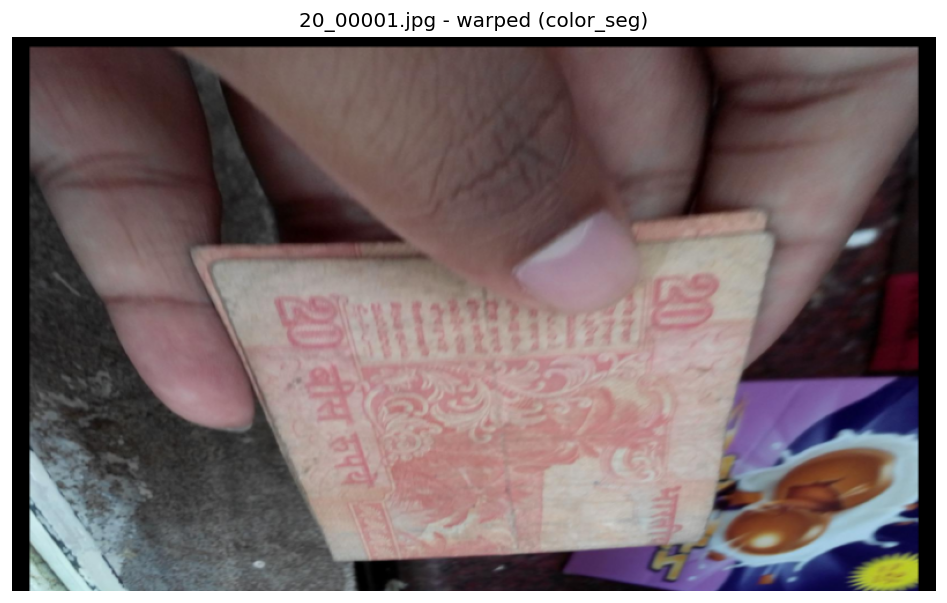

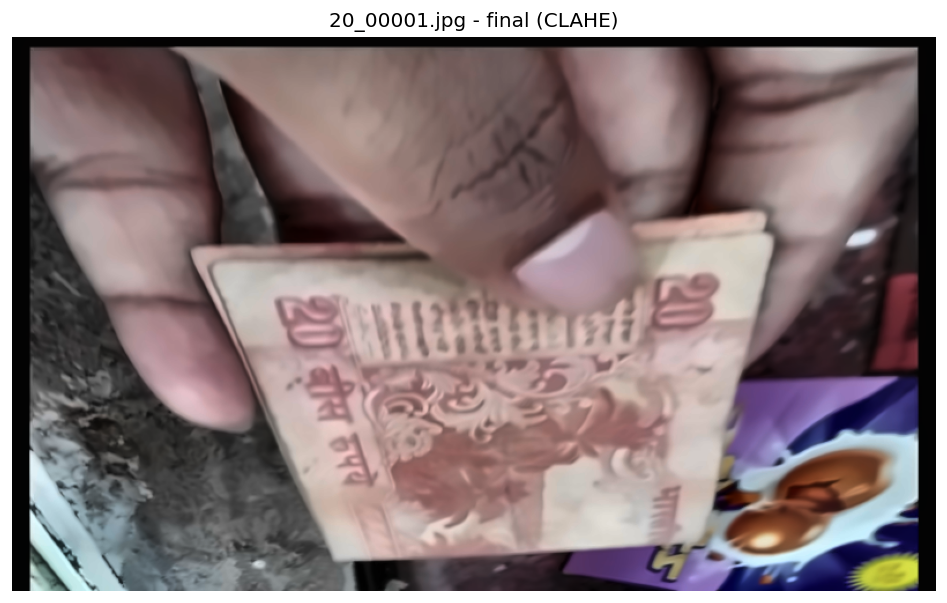

Processing: 20_00004.jpg
method: color_seg inliers: 0


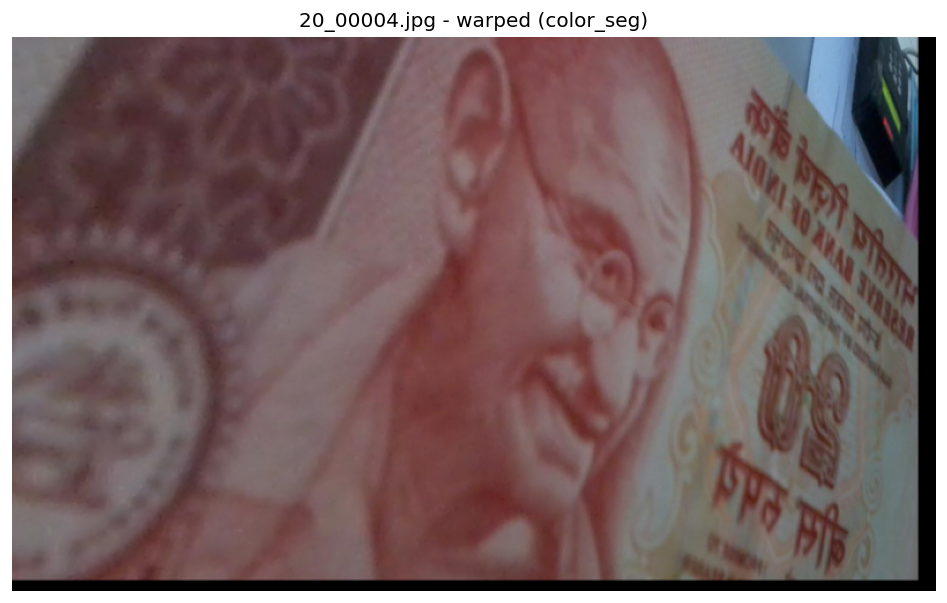

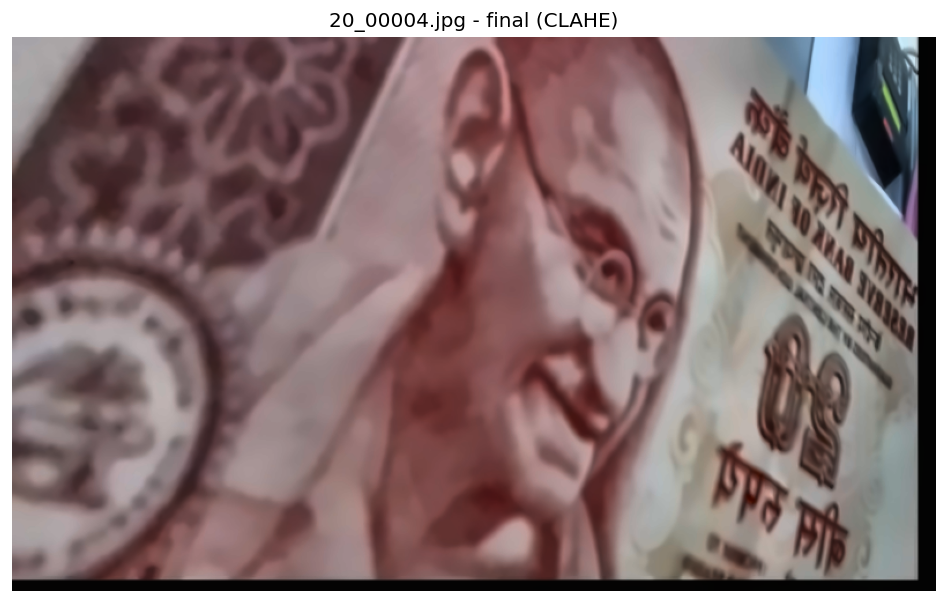

Processing: 20_00006.jpg
method: sift_template inliers: 66


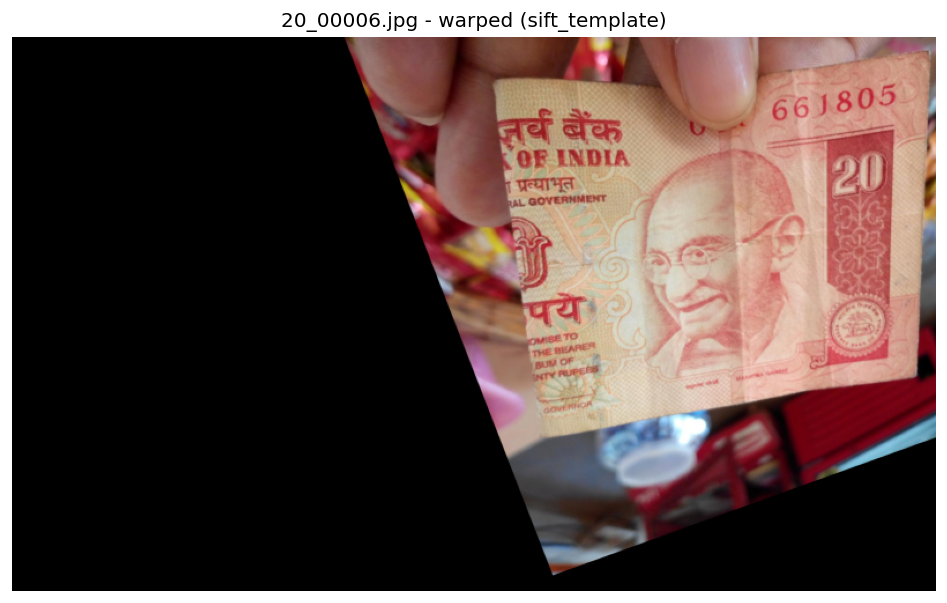

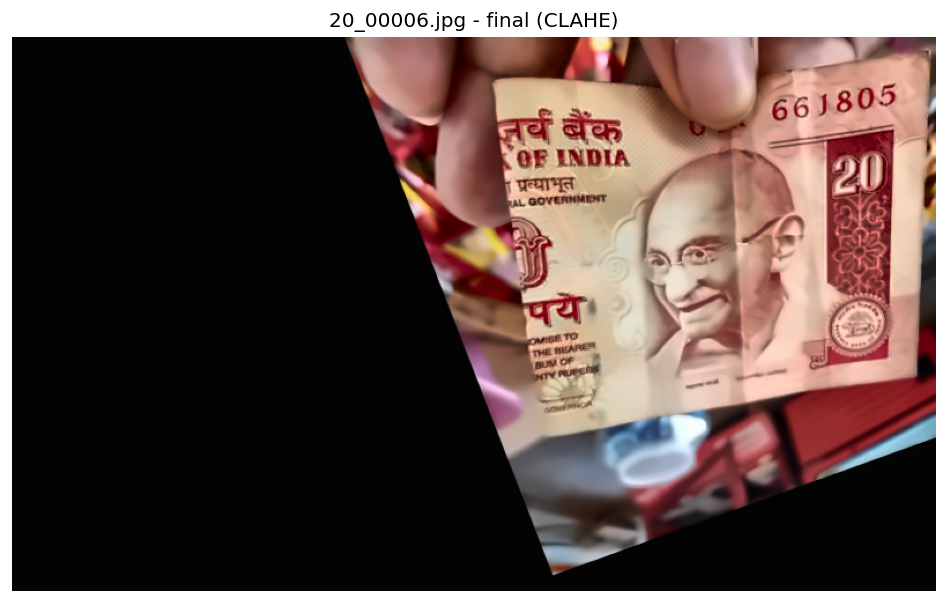

In [10]:
# Cell 10
print("templates folder exists?", TEMPLATE_DIR.exists())
template_list = []
if TEMPLATE_DIR.exists():
    for t in sorted(TEMPLATE_DIR.glob("*.jpg")):
        tpl = cv2.imread(str(t))
        if tpl is not None:
            template_list.append(tpl)
print("Loaded templates:", len(template_list))

results = {}
for p in sample_paths:
    print("Processing:", p.name)
    img = cv2.imread(str(p))
    if img is None:
        print("Cannot read", p)
        continue
    res = robust_localize_and_warp(img, template_list=template_list, target_size=(800,480), debug=False)
    res['final'] = apply_clahe_color(res['warped']) if res.get('warped') is not None else None
    results[p.name] = res
    print("method:", res['method'], "inliers:", res.get('inliers', None))
    imshow_rgb(res['warped'], title=f"{p.name} - warped ({res['method']})")
    imshow_rgb(res['final'], title=f"{p.name} - final (CLAHE)")

In [11]:
# Cell 12
artifacts_dir = Path("artifacts/warped")
artifacts_dir.mkdir(parents=True, exist_ok=True)

for name, res in results.items():
    if res.get('warped') is None:
        continue
    out_path = artifacts_dir / f"{name.replace('.jpg','')}_warped.jpg"
    cv2.imwrite(str(out_path), res['final'])
    print("Saved:", out_path)

Saved: artifacts/warped/20_00001_warped.jpg
Saved: artifacts/warped/20_00004_warped.jpg
Saved: artifacts/warped/20_00006_warped.jpg


In [12]:
# Cell 13 — Remove temporary outputs from Notebook 02
import shutil
from pathlib import Path

temp_dir = Path("artifacts/warped")
if temp_dir.exists():
    shutil.rmtree(temp_dir)
    print("Deleted old artifacts/warped/ directory.")
else:
    print("No old warped directory found. Clean.")

# Also clear any other temp files we created
extra_tmp = Path("artifacts/tmp")
if extra_tmp.exists():
    shutil.rmtree(extra_tmp)

print("Cleanup complete.")

Deleted old artifacts/warped/ directory.
Cleanup complete.


B

In [13]:
# === Cell 1: Imports & Paths ===
import os, json, time
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

DATASET_ROOT = Path("/kaggle/input/cvpr-mini-project-dataset/dataset")
TEMPLATE_DIR = DATASET_ROOT / "templates"

OUT_ROOT = Path("artifacts/preprocessed_fast")
STRICT_DIR = OUT_ROOT / "strict"        # used for DSV
CNN_DIR = OUT_ROOT / "cnn"              # used for CNN fallback images
LOG_PATH = OUT_ROOT / "preprocess_log.json"

STRICT_DIR.mkdir(parents=True, exist_ok=True)
CNN_DIR.mkdir(parents=True, exist_ok=True)

print("Output directories ready.")

Output directories ready.


In [14]:
# === Cell 2: Fast utilities ===

def resize_max(img, max_dim=1000):
    h, w = img.shape[:2]
    if max(h, w) <= max_dim:
        return img
    scale = max_dim / max(h, w)
    return cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

def order_points(pts):
    pts = np.array(pts, dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    rect = np.zeros((4,2), dtype="float32")
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def warp_quad(image, quad, out_size=(800,480)):
    rect = order_points(quad)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxW = int(max(widthA, widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxH = int(max(heightA, heightB))

    if maxW < 50 or maxH < 50:
        return None

    dst = np.array([
        [0, 0],
        [maxW-1, 0],
        [maxW-1, maxH-1],
        [0, maxH-1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxW, maxH))

    warped = cv2.resize(warped, out_size, interpolation=cv2.INTER_AREA)
    return warped

In [15]:
# === Cell 3: ORB + BRISK matcher (FAST and Kaggle-compatible) ===

def build_orb_brisk():
    orb = cv2.ORB_create(nfeatures=1500, fastThreshold=15)
    brisk = cv2.BRISK_create()
    return orb, brisk

orb, brisk = build_orb_brisk()

def detect_kp_desc(img):
    # ORB keypoints
    kp = orb.detect(img, None)
    if len(kp) == 0:
        return [], None

    # ORB computes keypoints first
    kp, desc_orb = orb.compute(img, kp)
    if desc_orb is None:
        return [], None

    # BRISK computes its own descriptors on those keypoints
    kp, desc_brisk = brisk.compute(img, kp)
    return kp, desc_brisk

In [16]:
# === Cell 4: Fast homography ===

def try_homography(img_gray, tpl_gray, min_inliers=20):
    kp1, d1 = detect_kp_desc(img_gray)
    kp2, d2 = detect_kp_desc(tpl_gray)

    if d1 is None or d2 is None or len(kp1) < 10 or len(kp2) < 10:
        return None, 0

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(d2, d1)

    if len(matches) < 10:
        return None, 0

    matches = sorted(matches, key=lambda x: x.distance)[:80]  # keep best 80

    src = np.float32([kp2[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 4.0)
    if H is None:
        return None, 0

    inliers = int(mask.sum())
    if inliers < min_inliers:
        return None, inliers

    return H, inliers

In [17]:
# === Cell 5: Load templates and matcher ===
template_list = []
for t in TEMPLATE_DIR.glob("*.jpg"):
    tpl = cv2.imread(str(t))
    if tpl is not None:
        template_list.append(cv2.cvtColor(tpl, cv2.COLOR_BGR2GRAY))

print("Templates loaded:", len(template_list))

Templates loaded: 21


In [18]:
# === Cell 6: Fast pre-filter ===

def is_likely_full_note(img_gray):
    h, w = img_gray.shape
    edges = cv2.Canny(img_gray, 60, 160)
    edge_ratio = edges.mean()

    if edge_ratio < 0.015:      # too smooth
        return False
    if edge_ratio > 0.25:       # too noisy
        return False

    blur = cv2.Laplacian(img_gray, cv2.CV_64F).var()
    if blur < 40:               # too blurry
        return False

    return True

In [19]:
# === Cell 7: full pipeline warp ===

def fast_preprocess(img):
    img_small = resize_max(img, 900)
    g = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY)

    # Stage 1: fast filter
    full_note = is_likely_full_note(g)

    # Stage 2: template matching only if likely full note
    if full_note:
        best_inliers = -1
        best_quad = None
        for tpl_gray in template_list:
            H, inl = try_homography(g, tpl_gray)
            if H is not None and inl > best_inliers:
                htpl, wtpl = tpl_gray.shape
                tpl_corners = np.float32([[0,0],[wtpl,0],[wtpl,htpl],[0,htpl]])
                quad = cv2.perspectiveTransform(tpl_corners.reshape(-1,1,2), H).reshape(4,2)
                best_quad = quad
                best_inliers = inl

        if best_quad is not None and best_inliers >= 20:
            warped = warp_quad(img_small, best_quad)
            if warped is not None:
                return warped, "strict", best_inliers

    # Stage 3: fallback - center crop
    h, w = img_small.shape[:2]
    cc = img_small[int(0.1*h):int(0.9*h), int(0.1*w):int(0.9*w)]
    cc = cv2.resize(cc, (800,480))
    return cc, "fallback", 0

In [20]:
# === Cell 8: Full dataset processing===

# load log if exists
if LOG_PATH.exists():
    with open(LOG_PATH, "r") as f:
        log = json.load(f)
else:
    log = {}

splits = ["train","validation","test"]

for split in splits:
    print(f"\n=== Processing {split} ===")
    IN_DIR = DATASET_ROOT / split

    # output dirs
    STRICT_SPLIT = STRICT_DIR / split
    CNN_SPLIT    = CNN_DIR / split
    STRICT_SPLIT.mkdir(parents=True, exist_ok=True)
    CNN_SPLIT.mkdir(parents=True, exist_ok=True)

    images = sorted(IN_DIR.rglob("*.jpg"))
    print(f"{len(images)} images.")

    for p in tqdm(images):
        key = f"{split}/{p.name}"
        if key in log:
            continue

        img = cv2.imread(str(p))
        if img is None:
            log[key] = {"status":"read_fail"}
            continue

        warped, mode, inliers = fast_preprocess(img)

        # Extract original class label (folder name)
        label = p.parent.name

        # Create output directories WITH CLASS LABELS
        if mode == "strict":
            out_dir = STRICT_SPLIT / label
        else:
            out_dir = CNN_SPLIT / label

        out_dir.mkdir(parents=True, exist_ok=True)

        out_path = out_dir / p.name
        cv2.imwrite(str(out_path), warped)

        log[key] = {
            "status": mode,
            "inliers": inliers,
            "out": str(out_path)
        }

        # flush every 150 images
        if len(log) % 150 == 0:
            with open(LOG_PATH,"w") as f:
                json.dump(log, f, indent=2)
            print("Checkpoint saved.")

# final log flush
with open(LOG_PATH,"w") as f:
    json.dump(log, f, indent=2)

print("\nAll done. Log saved at:", LOG_PATH)


=== Processing train ===
9253 images.


  2%|▏         | 152/9253 [00:13<12:28, 12.17it/s]

Checkpoint saved.


  3%|▎         | 303/9253 [00:26<12:15, 12.17it/s]

Checkpoint saved.


  5%|▍         | 452/9253 [00:40<11:48, 12.42it/s]

Checkpoint saved.


  7%|▋         | 602/9253 [00:50<09:23, 15.35it/s]

Checkpoint saved.


  8%|▊         | 751/9253 [01:06<13:22, 10.60it/s]

Checkpoint saved.


 10%|▉         | 900/9253 [01:20<13:26, 10.35it/s]

Checkpoint saved.


 11%|█▏        | 1049/9253 [01:34<20:36,  6.63it/s]

Checkpoint saved.


 13%|█▎        | 1201/9253 [01:56<18:00,  7.45it/s]

Checkpoint saved.


 15%|█▍        | 1351/9253 [02:13<18:27,  7.13it/s]

Checkpoint saved.


 16%|█▌        | 1500/9253 [02:31<21:13,  6.09it/s]

Checkpoint saved.


 18%|█▊        | 1650/9253 [02:50<10:43, 11.82it/s]

Checkpoint saved.


 19%|█▉        | 1800/9253 [03:10<19:13,  6.46it/s]

Checkpoint saved.


 21%|██        | 1948/9253 [03:27<10:23, 11.72it/s]

Checkpoint saved.


 23%|██▎       | 2100/9253 [03:45<14:29,  8.23it/s]

Checkpoint saved.


 24%|██▍       | 2250/9253 [04:03<12:11,  9.57it/s]

Checkpoint saved.


 26%|██▌       | 2400/9253 [04:23<16:48,  6.79it/s]

Checkpoint saved.


 28%|██▊       | 2552/9253 [04:40<10:50, 10.31it/s]

Checkpoint saved.


 29%|██▉       | 2705/9253 [04:51<05:16, 20.69it/s]

Checkpoint saved.


 31%|███       | 2855/9253 [05:00<04:21, 24.50it/s]

Checkpoint saved.


 32%|███▏      | 3000/9253 [05:20<09:08, 11.41it/s]

Checkpoint saved.


 34%|███▍      | 3153/9253 [05:31<06:19, 16.07it/s]

Checkpoint saved.


 36%|███▌      | 3304/9253 [05:43<05:14, 18.93it/s]

Checkpoint saved.


 37%|███▋      | 3455/9253 [05:53<04:32, 21.28it/s]

Checkpoint saved.


 39%|███▉      | 3601/9253 [06:05<05:15, 17.94it/s]

Checkpoint saved.


 41%|████      | 3750/9253 [06:17<05:22, 17.06it/s]

Checkpoint saved.


 42%|████▏     | 3901/9253 [06:37<14:10,  6.29it/s]

Checkpoint saved.


 44%|████▍     | 4051/9253 [06:58<13:36,  6.37it/s]

Checkpoint saved.


 45%|████▌     | 4201/9253 [07:20<11:44,  7.17it/s]

Checkpoint saved.


 47%|████▋     | 4351/9253 [07:42<12:25,  6.57it/s]

Checkpoint saved.


 49%|████▊     | 4501/9253 [08:04<11:55,  6.64it/s]

Checkpoint saved.


 50%|█████     | 4651/9253 [08:26<10:50,  7.07it/s]

Checkpoint saved.


 52%|█████▏    | 4801/9253 [08:48<10:20,  7.18it/s]

Checkpoint saved.


 54%|█████▎    | 4951/9253 [09:10<11:12,  6.39it/s]

Checkpoint saved.


 55%|█████▌    | 5101/9253 [09:31<09:58,  6.93it/s]

Checkpoint saved.


 57%|█████▋    | 5251/9253 [09:52<09:27,  7.05it/s]

Checkpoint saved.


 58%|█████▊    | 5401/9253 [10:14<09:43,  6.60it/s]

Checkpoint saved.


 60%|█████▉    | 5551/9253 [10:37<09:41,  6.37it/s]

Checkpoint saved.


 62%|██████▏   | 5701/9253 [10:59<08:53,  6.65it/s]

Checkpoint saved.


 63%|██████▎   | 5851/9253 [11:21<08:16,  6.85it/s]

Checkpoint saved.


 65%|██████▍   | 6001/9253 [11:43<07:51,  6.89it/s]

Checkpoint saved.


 66%|██████▋   | 6151/9253 [12:05<07:26,  6.95it/s]

Checkpoint saved.


 68%|██████▊   | 6302/9253 [12:24<04:15, 11.53it/s]

Checkpoint saved.


 70%|██████▉   | 6454/9253 [12:37<02:49, 16.48it/s]

Checkpoint saved.


 71%|███████▏  | 6601/9253 [13:00<02:57, 14.96it/s]

Checkpoint saved.


 73%|███████▎  | 6751/9253 [13:14<03:17, 12.67it/s]

Checkpoint saved.


 75%|███████▍  | 6901/9253 [13:30<04:50,  8.11it/s]

Checkpoint saved.


 76%|███████▌  | 7050/9253 [13:45<05:51,  6.26it/s]

Checkpoint saved.


 78%|███████▊  | 7200/9253 [14:00<03:36,  9.47it/s]

Checkpoint saved.


 79%|███████▉  | 7350/9253 [14:14<02:34, 12.33it/s]

Checkpoint saved.


 81%|████████  | 7501/9253 [14:30<03:52,  7.55it/s]

Checkpoint saved.


 83%|████████▎ | 7651/9253 [14:45<02:51,  9.33it/s]

Checkpoint saved.


 84%|████████▍ | 7801/9253 [15:01<03:00,  8.04it/s]

Checkpoint saved.


 86%|████████▌ | 7951/9253 [15:18<02:28,  8.74it/s]

Checkpoint saved.


 88%|████████▊ | 8104/9253 [15:35<01:30, 12.65it/s]

Checkpoint saved.


 89%|████████▉ | 8251/9253 [15:51<01:58,  8.48it/s]

Checkpoint saved.


 91%|█████████ | 8402/9253 [16:07<01:19, 10.64it/s]

Checkpoint saved.


 92%|█████████▏| 8553/9253 [16:23<00:58, 12.05it/s]

Checkpoint saved.


 94%|█████████▍| 8702/9253 [16:39<00:45, 12.04it/s]

Checkpoint saved.


 96%|█████████▌| 8851/9253 [17:04<01:38,  4.07it/s]

Checkpoint saved.


 97%|█████████▋| 9007/9253 [17:14<00:05, 45.22it/s]

Checkpoint saved.


 99%|█████████▉| 9160/9253 [17:17<00:01, 51.63it/s]

Checkpoint saved.


100%|██████████| 9253/9253 [17:19<00:00,  8.90it/s]



=== Processing validation ===
1981 images.


  3%|▎         | 52/1981 [00:03<01:39, 19.42it/s]

Checkpoint saved.


 10%|█         | 200/1981 [00:16<02:04, 14.36it/s]

Checkpoint saved.


 18%|█▊        | 348/1981 [00:31<03:14,  8.41it/s]

Checkpoint saved.


 25%|██▌       | 498/1981 [00:48<03:32,  6.98it/s]

Checkpoint saved.


 33%|███▎      | 648/1981 [00:59<01:29, 14.96it/s]

Checkpoint saved.


 40%|████      | 800/1981 [01:11<01:03, 18.62it/s]

Checkpoint saved.


 48%|████▊     | 948/1981 [01:32<02:54,  5.91it/s]

Checkpoint saved.


 55%|█████▌    | 1098/1981 [01:52<02:10,  6.76it/s]

Checkpoint saved.


 63%|██████▎   | 1248/1981 [02:13<01:45,  6.93it/s]

Checkpoint saved.


 71%|███████   | 1398/1981 [02:33<01:25,  6.78it/s]

Checkpoint saved.


 78%|███████▊  | 1549/1981 [02:49<00:37, 11.53it/s]

Checkpoint saved.


 86%|████████▌ | 1699/1981 [03:07<00:36,  7.67it/s]

Checkpoint saved.


 93%|█████████▎| 1848/1981 [03:27<00:16,  8.23it/s]

Checkpoint saved.


100%|██████████| 1981/1981 [03:37<00:00,  9.11it/s]



=== Processing test ===
1990 images.


  1%|          | 19/1990 [00:01<01:55, 17.03it/s]

Checkpoint saved.


  8%|▊         | 166/1990 [00:15<02:38, 11.53it/s]

Checkpoint saved.


 16%|█▌        | 317/1990 [00:41<04:23,  6.35it/s]

Checkpoint saved.


 23%|██▎       | 467/1990 [00:59<02:43,  9.33it/s]

Checkpoint saved.


 31%|███       | 619/1990 [01:14<01:23, 16.43it/s]

Checkpoint saved.


 39%|███▊      | 770/1990 [01:26<01:04, 18.84it/s]

Checkpoint saved.


 46%|████▌     | 917/1990 [01:48<03:25,  5.23it/s]

Checkpoint saved.


 54%|█████▎    | 1067/1990 [02:15<02:57,  5.19it/s]

Checkpoint saved.


 61%|██████    | 1217/1990 [02:37<01:58,  6.54it/s]

Checkpoint saved.


 69%|██████▊   | 1367/1990 [02:59<00:57, 10.91it/s]

Checkpoint saved.


 76%|███████▋  | 1521/1990 [03:14<00:33, 14.09it/s]

Checkpoint saved.


 84%|████████▍ | 1667/1990 [03:29<00:41,  7.74it/s]

Checkpoint saved.


 91%|█████████▏| 1817/1990 [03:45<00:22,  7.74it/s]

Checkpoint saved.


 99%|█████████▉| 1975/1990 [03:58<00:00, 52.99it/s]

Checkpoint saved.


100%|██████████| 1990/1990 [03:58<00:00,  8.35it/s]



All done. Log saved at: artifacts/preprocessed_fast/preprocess_log.json


In [21]:
# === Cell 9: Summary ===
counts = {"strict":0, "fallback":0, "read_fail":0}
for k,v in log.items():
    counts[v["status"]] += 1

print("=== SUMMARY ===")
print(counts)

=== SUMMARY ===
{'strict': 0, 'fallback': 13224, 'read_fail': 0}


C

In [22]:
# Cell 1
import os, json, time
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

DATASET_ROOT = Path("/kaggle/input/cvpr-mini-project-dataset/dataset")
TEMPLATE_DIR = DATASET_ROOT / "templates"

OUT_ROOT = Path("artifacts/preprocessed_fast")
STRICT_DIR = OUT_ROOT / "strict"        # used for DSV
CNN_DIR = OUT_ROOT / "cnn"              # used for CNN fallback images
LOG_PATH = OUT_ROOT / "preprocess_log.json"

STRICT_DIR.mkdir(parents=True, exist_ok=True)
CNN_DIR.mkdir(parents=True, exist_ok=True)

print("Output directories ready.")
print("DATASET_ROOT:", DATASET_ROOT)
print("TEMPLATE_DIR:", TEMPLATE_DIR)

Output directories ready.
DATASET_ROOT: /kaggle/input/cvpr-mini-project-dataset/dataset
TEMPLATE_DIR: /kaggle/input/cvpr-mini-project-dataset/dataset/templates


In [23]:
# Cell 2
def resize_max(img, max_dim=1000):
    h, w = img.shape[:2]
    if max(h, w) <= max_dim:
        return img
    scale = max_dim / max(h, w)
    return cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

def order_points(pts):
    pts = np.array(pts, dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    rect = np.zeros((4,2), dtype="float32")
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def warp_quad(image, quad, out_size=(800,480), extra_border=0.02):
    rect = order_points(quad)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxW = int(max(widthA, widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxH = int(max(heightA, heightB))
    if maxW < 50 or maxH < 50:
        return None
    pad_w = int(maxW * extra_border)
    pad_h = int(maxH * extra_border)
    dst = np.array([[0+pad_w,0+pad_h],[maxW-1-pad_w,0+pad_h],[maxW-1-pad_w,maxH-1-pad_h],[0+pad_w,maxH-1-pad_h]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxW, maxH))
    try:
        warped = cv2.resize(warped, out_size, interpolation=cv2.INTER_AREA)
    except:
        return None
    return warped

def homography_sanity(mapped_corners, img_shape, min_area_ratio=0.01, max_aspect=6.0):
    # mapped_corners: (4,2)
    h, w = img_shape[:2]
    # polygon area via shoelace
    x = mapped_corners[:,0]; y = mapped_corners[:,1]
    area = 0.5 * abs(np.dot(x, np.roll(y,1)) - np.dot(y, np.roll(x,1)))
    if area < min_area_ratio * h * w:
        return False
    bw = x.max() - x.min(); bh = y.max() - y.min()
    if bw <= 20 or bh <= 20:
        return False
    aspect = bw / max(bh,1)
    if aspect > max_aspect or aspect < 1.0/max_aspect:
        return False
    return True

In [24]:
# Cell 3
def build_akaze():
    try:
        ak = cv2.AKAZE_create()
        return ak
    except Exception as e:
        print("AKAZE not available:", e)
        return None

def build_sift():
    if hasattr(cv2, "SIFT_create"):
        return cv2.SIFT_create()
    try:
        return cv2.xfeatures2d.SIFT_create()
    except Exception:
        return None

def match_desc(desc_query, desc_train, crossCheck=True):
    # choose matcher depending on descriptor dtype
    if desc_query is None or desc_train is None:
        return []
    if desc_query.dtype == np.uint8 or desc_train.dtype == np.uint8:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    else:
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    matches = matcher.match(desc_query, desc_train)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

In [25]:
# Cell 4
def find_homography_with_detector(detector, img_gray, tpl_gray, min_inliers=20, keep_top=120):
    kp1, desc1 = detector.detectAndCompute(img_gray, None)
    kp2, desc2 = detector.detectAndCompute(tpl_gray, None)
    if desc1 is None or desc2 is None or len(kp1) < 6 or len(kp2) < 6:
        return None, 0
    matches = match_desc(desc2, desc1)  # template -> image
    if len(matches) < 8:
        return None, len(matches)
    matches = matches[:keep_top]
    src = np.float32([kp2[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 4.0)
    if H is None:
        return None, 0
    inliers = int(mask.sum())
    if inliers < min_inliers:
        return None, inliers
    return H, inliers

In [26]:
# Cell 5
template_list = []
template_shapes = []
if TEMPLATE_DIR.exists():
    for t in sorted(TEMPLATE_DIR.glob("*.jpg")):
        tpl = cv2.imread(str(t))
        if tpl is not None:
            tpl_g = cv2.cvtColor(tpl, cv2.COLOR_BGR2GRAY)
            template_list.append(tpl_g)
            template_shapes.append(tpl_g.shape)
print("Loaded templates:", len(template_list))
if len(template_list)==0:
    raise RuntimeError("No templates found at: " + str(TEMPLATE_DIR))

Loaded templates: 21


In [27]:
# Cell 6
def is_likely_full_note(img_gray):
    h, w = img_gray.shape
    edges = cv2.Canny(img_gray, 60, 160)
    edge_ratio = edges.sum() / (h*w*255.0)  # normalized
    lap_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()
    # heuristics (tunable)
    if edge_ratio < 0.01:   # too smooth, likely closeup blank area
        return False
    if lap_var < 30:        # too blurry
        return False
    return True

In [28]:
# Cell 7
akaze = build_akaze()
sift = build_sift()
print("AKAZE:", "OK" if akaze is not None else "Missing", "SIFT:", "OK" if sift is not None else "Missing")

def robust_akaze_sift_warp(img, target_size=(800,480), debug=False):
    img_small = resize_max(img, max_dim=1000)
    img_gray = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY)

    # quick filter
    if not is_likely_full_note(img_gray):
        # fallback center crop (for CNN)
        h, w = img_small.shape[:2]
        cc = img_small[int(0.1*h):int(0.9*h), int(0.1*w):int(0.9*w)]
        cc = cv2.resize(cc, target_size)
        return {"warped": cc, "method": "prefilter_fallback", "inliers": 0}

    # Try AKAZE template-by-template
    if akaze is not None:
        best_inliers = -1
        best_quad = None
        for tpl_gray, tpl_shape in zip(template_list, template_shapes):
            H_inl = find_homography_with_detector(akaze, img_gray, tpl_gray, min_inliers=18, keep_top=100)
            if H_inl is None or H_inl[0] is None:
                # H_inl may be (None, n) or None
                continue
            H, inliers = H_inl
            if inliers > best_inliers:
                # map template corners
                h_tpl, w_tpl = tpl_shape
                tpl_corners = np.float32([[0,0],[w_tpl-1,0],[w_tpl-1,h_tpl-1],[0,h_tpl-1]]).reshape(-1,1,2)
                mapped = cv2.perspectiveTransform(tpl_corners, H).reshape(4,2)
                if homography_sanity(mapped, img_small.shape, min_area_ratio=0.01, max_aspect=6.0):
                    best_inliers = inliers
                    best_quad = mapped

        if best_quad is not None:
            warped = warp_quad(img_small, best_quad, out_size=target_size)
            if warped is not None:
                return {"warped": warped, "method": "akaze", "inliers": best_inliers}

    # AKAZE failed -> try SIFT if available (stronger)
    if sift is not None:
        best_inliers = -1
        best_quad = None
        for tpl_gray, tpl_shape in zip(template_list, template_shapes):
            H_inl = find_homography_with_detector(sift, img_gray, tpl_gray, min_inliers=28, keep_top=160)
            if H_inl is None or H_inl[0] is None:
                continue
            H, inliers = H_inl
            if inliers > best_inliers:
                h_tpl, w_tpl = tpl_shape
                tpl_corners = np.float32([[0,0],[w_tpl-1,0],[w_tpl-1,h_tpl-1],[0,h_tpl-1]]).reshape(-1,1,2)
                mapped = cv2.perspectiveTransform(tpl_corners, H).reshape(4,2)
                if homography_sanity(mapped, img_small.shape, min_area_ratio=0.01, max_aspect=6.0):
                    best_inliers = inliers
                    best_quad = mapped

        if best_quad is not None:
            warped = warp_quad(img_small, best_quad, out_size=target_size)
            if warped is not None:
                return {"warped": warped, "method": "sift", "inliers": best_inliers}

    # final fallback center crop
    h, w = img_small.shape[:2]
    cc = img_small[int(0.1*h):int(0.9*h), int(0.1*w):int(0.9*w)]
    cc = cv2.resize(cc, (800,480))
    return {"warped": cc, "method": "final_fallback", "inliers": 0}

AKAZE: OK SIFT: OK


In [29]:
# === Cell 8: Process dataset===

# Load existing log if exists (resume)
if LOG_PATH.exists():
    with open(LOG_PATH, "r") as f:
        log = json.load(f)
else:
    log = {}

splits = ["train","validation","test"]
processed = 0
flush_every = 120   # flush JSON every N images

for split in splits:
    IN_DIR = DATASET_ROOT / split

    out_strict = STRICT_DIR / split
    out_cnn = CNN_DIR / split
    out_strict.mkdir(parents=True, exist_ok=True)
    out_cnn.mkdir(parents=True, exist_ok=True)

    file_list = sorted(IN_DIR.rglob("*.jpg"))
    print(f"Processing split {split} - {len(file_list)} images")

    for p in tqdm(file_list):
        key = f"{split}/{p.name}"
        if key in log:
            continue

        img = cv2.imread(str(p))
        if img is None:
            log[key] = {"status":"read_fail"}
            continue

        res = robust_akaze_sift_warp(img, target_size=(800,480))
        warped = res.get("warped")
        method = res.get("method", "none")
        inliers = res.get("inliers", 0)

        # Extract original class label (folder name)
        label = p.parent.name

        if warped is None:
            log[key] = {
                "status":"rejected",
                "method":method,
                "inliers":inliers
            }
        else:
            # Decide strict vs fallback
            if method in ("akaze","sift"):
                out_dir = out_strict / label
            else:
                out_dir = out_cnn / label

            out_dir.mkdir(parents=True, exist_ok=True)

            out_path = out_dir / p.name
            cv2.imwrite(str(out_path), warped)

            log[key] = {
                "status":"strict" if method in ("akaze","sift") else "fallback",
                "method":method,
                "inliers":inliers,
                "out":str(out_path)
            }

        processed += 1
        if processed % flush_every == 0:
            with open(LOG_PATH,"w") as f:
                json.dump(log, f, indent=2)
            print(time.strftime("%X"), "- checkpoint flush - processed:", processed)

# final flush
with open(LOG_PATH,"w") as f:
    json.dump(log, f, indent=2)

print("Processing completed. Log at:", LOG_PATH)

Processing split train - 9253 images


100%|██████████| 9253/9253 [00:00<00:00, 1202400.93it/s]


Processing split validation - 1981 images


100%|██████████| 1981/1981 [00:00<00:00, 847416.24it/s]


Processing split test - 1990 images


100%|██████████| 1990/1990 [00:00<00:00, 772910.91it/s]

Processing completed. Log at: artifacts/preprocessed_fast/preprocess_log.json


In [30]:
# Cell 9
from collections import Counter
ctr = Counter()
for v in log.values():
    ctr[v["status"]] += 1
print("=== SUMMARY ===")
print(dict(ctr))
print("Strict dir examples (first 5):")
print(sorted(STRICT_DIR.rglob("*.jpg"))[:5])
print("Fallback dir examples (first 5):")
print(sorted(CNN_DIR.rglob("*.jpg"))[:5])

=== SUMMARY ===
{'fallback': 13224}
Strict dir examples (first 5):
[]
Fallback dir examples (first 5):
[PosixPath('artifacts/preprocessed_fast/cnn/test/denomination_10/10_00000.jpg'), PosixPath('artifacts/preprocessed_fast/cnn/test/denomination_10/10_00001.jpg'), PosixPath('artifacts/preprocessed_fast/cnn/test/denomination_10/10_00002.jpg'), PosixPath('artifacts/preprocessed_fast/cnn/test/denomination_10/10_00003.jpg'), PosixPath('artifacts/preprocessed_fast/cnn/test/denomination_10/10_00004.jpg')]
